# Numerical Solutions to PDEs (one dimension)

# Finite Volume Method 

https://projects.skill-lync.com/projects/FVM-schemes-49852
https://floringh.gitbooks.io/computational-fluid-dynamics/1dLinearConvection.html

## Convection–diffusion equation

$$ \frac{\partial\phi}{\partial t} = -\nabla\cdot(\mathbf{u}\phi) +\nabla\cdot(D\nabla\phi)+R $$

where $\phi$is the variable of interest. $\mathbf{u}$  is the velocity field that the quantity $\phi$ is moving with. $D$ is the diffusivity. $R$ describes sources or sinks of the quantity.

https://github.com/simulkade/JFVM.jl

$$ \int_{c.v.}\frac{\partial\phi}{\partial t} dV= -\int_{c.v.}\nabla\cdot(\mathbf{u}\phi) dV+
\int_{c.v.}\nabla\cdot(D\nabla\phi)dV+
\int_{c.v.}RdV $$

## 1D Linear Convection

From the **convection–diffusion equation** we kept only the accumulation and convection terms. To make things simpler, consider the velocity $\mathbf{u}$ of the convection terms is constant. The 1D linear convection equation is written as follows


$$ \frac{\partial\phi}{\partial t} = = -c\frac{\partial\phi}{\partial x} = $$

where $\phi$ is a function of $x$ and $t$ while $c$ is the constant velocity.

It can be proven that if the initial condition is $\phi(x, 0) = \phi_0(x)$, then the exact solution is $\phi(x, t) = \phi_0(x - ct)$.

## Gradient Scheme

The gradient schemes are used to calculate **the variable gradient on the face**. We use variable from neighbouring control volume and numerically evaluate the variable gradient.

## Interpolation Scheme

https://projects.skill-lync.com/projects/FVM-Interpolation-Scheme-and-flux-limiter-65325

https://projects.skill-lync.com/projects/FVM-Interpolation-and-Gradient-Schemes-literature-review-26860

Evaluation of surface and volume integral usually required the value of variable at location other than the computational node of control volume. To obtain the unkown value at these loations, we need to apply interpolation schemes.

### a. Upwind Difference Scheme

### b. Central Difference Scheme

### c. Quadratic Upstream Interpolation Scheme (QUICK)

## Flux Limiter

Total Variation Diminishing Scheme

## Julia code

### Importing library

In [1]:
using Printf
using DelimitedFiles

## Configuration data struct

In [2]:
@enum InterpolationType UPWIND LINEAR QUICK
@enum TimeMarchingType RK1 RK2 RK4
    
mutable struct CaseConfig
    MIN_X::Float64
    MAX_X::Float64
    NUM_X_CELLS::Int64
    NUM_TIME_STEPS::Int64
    TIME_STEPS_SIZE::Float64
    CONVECTION_VEL::Float64
    
    VAR_INTERPOLATION_TYPE::InterpolationType
    TIME_MARCHING_TYPE::TimeMarchingType
    NUM_GHOST_CELLS::Int64
    NUM_RK_STEPS::Int64
    
    function CaseConfig(MIN_X::Float64, MAX_X::Float64, NUM_X_CELLS::Int64, NUM_TIME_STEPS::Int64, TIME_STEPS_SIZE::Float64, 
                        CONVECTION_VEL::Float64, VAR_INTERPOLATION_TYPE::InterpolationType, TIME_MARCHING_TYPE::TimeMarchingType)
        this = new()
    
        this.MIN_X = MIN_X
        this.MAX_X = MAX_X
        this.NUM_X_CELLS = NUM_X_CELLS
        this.NUM_TIME_STEPS = NUM_TIME_STEPS
        this.TIME_STEPS_SIZE = TIME_STEPS_SIZE
        this.CONVECTION_VEL = CONVECTION_VEL

        this.VAR_INTERPOLATION_TYPE = VAR_INTERPOLATION_TYPE
        if this.VAR_INTERPOLATION_TYPE == UPWIND
            this.NUM_GHOST_CELLS = 1
        elseif this.VAR_INTERPOLATION_TYPE == LINEAR
            this.NUM_GHOST_CELLS = 1
        elseif this.VAR_INTERPOLATION_TYPE == QUICK
            this.NUM_GHOST_CELLS = 2
        end
        
        this.TIME_MARCHING_TYPE = TIME_MARCHING_TYPE
        if this.TIME_MARCHING_TYPE == RK1
            this.NUM_RK_STEPS = 1
        elseif this.TIME_MARCHING_TYPE == RK2
            this.NUM_RK_STEPS = 2
        elseif this.TIME_MARCHING_TYPE == RK4
            this.NUM_RK_STEPS = 3
        end
    
        return this
    end
    
end

function Base.show(io::IO, ::MIME"text/plain", config::CaseConfig)
    for fname in fieldnames(typeof(config))
        println(io, "$fname = ",  getfield(config, fname))
    end
end



## Cell data struct / Mesh data struct 

In [3]:
mutable struct Cell
    # 1 dimensional cell data
    CENTER_POS::Float64
    WEST_FACE_POS::Float64
    EAST_FACE_POS::Float64

    CELL_SIZE::Float64
    CELL_VAR::Array{Float64,1}

    WEST_FACE_VAR::Float64
    EAST_FACE_VAR::Float64

    WEST_FACE_UNITNORM::Float64
    EAST_FACE_UNITNORM::Float64

    CELL_FLUX::Array{Float64,1}
    
    function Cell(config::CaseConfig, start_pos::Float64)
        this = new()
    
        dx = (config.MAX_X - config.MIN_X) / config.NUM_X_CELLS
        this.CELL_SIZE = dx
    
        this.CELL_VAR = zeros(config.NUM_RK_STEPS+1)
        this.CELL_FLUX = zeros(config.NUM_RK_STEPS)
    
        this.CENTER_POS = start_pos + dx*0.5
        this.WEST_FACE_POS = start_pos 
        this.EAST_FACE_POS = start_pos + dx
    
        this.WEST_FACE_UNITNORM = -1.0
        this.EAST_FACE_UNITNORM = 1.0
    
        return this
    end
    
end


mutable struct Mesh
    # 1 dimensional mesh data
    CELLs::Array{Cell,1}

    function Mesh(config::CaseConfig)
        this = new()
        
        CELLs = Array{Cell,1}(undef,config.NUM_X_CELLS)
        start_pos = 0.0
        for idx = 1 : length(CELLs)
            CELLs[idx] = Cell(config, start_pos)
            start_pos = CELLs[idx].EAST_FACE_POS
        end
        this.CELLs = CELLs
        return this
    end
    
end

## Initializer struct

In [7]:
struct SquareWaveInitializer
    REC_WAVE_START::Float64
    REC_WAVE_END::Float64
end

function INITIALIZE(initializer::SquareWaveInitializer, mesh::Mesh)
    
    for each_cell in mesh.CELLs
        for idx = 1 : length(each_cell.CELL_VAR)
            if ( each_cell.CENTER_POS >= initializer.REC_WAVE_START &&
                 each_cell.CENTER_POS <= initializer.REC_WAVE_END )
                 each_cell.CELL_VAR[idx] = 1.0
            else
                 each_cell.CELL_VAR[idx] = 0.0
            end
        end
    end
    
end

INITIALIZE (generic function with 1 method)

## Interpolation function

In [7]:
# Calculate VAR on two sides of each cell
function InterpolationFun(case::CaseConfig, cells::Array{Cell,1}, rkSteps)
    # ===================================================================     
    # UPWING INTERPOLATION
    # ===================================================================     
    if case.VAR_INTERPOLATION_TYPE == UPWIND
        for idx = case.NUM_GHOST_CELLS+1 : case.NUM_GHOST_CELLS + case.NUM_X_CELLS
            P_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
            E_CELL_VAR = cells[idx+1].CELL_VAR[rkSteps]
            W_CELL_VAR = cells[idx-1].CELL_VAR[rkSteps]
            
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].WEST_FACE_UNITNORM)
            
            cells[idx].WEST_FACE_VAR = ( 0.5*advec_sign*(W_CELL_VAR + P_CELL_VAR) -
                                         0.5*abs(advec_sign)*(W_CELL_VAR - P_CELL_VAR) )*advec_sign
            
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].EAST_FACE_UNITNORM)
            
            cells[idx].EAST_FACE_VAR =( 0.5*advec_sign*(E_CELL_VAR + P_CELL_VAR) -
                                        0.5*abs(advec_sign)*(E_CELL_VAR - P_CELL_VAR) )*advec_sign
            
        end
    # ===================================================================     
    # LINEAR INTERPOLATION
    # ===================================================================    
    elseif case.VAR_INTERPOLATION_TYPE == LINEAR
        for idx = case.NUM_GHOST_CELLS + 1 : case.NUM_GHOST_CELLS + case.NUM_X_CELLS
            P_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
            E_CELL_VAR = cells[idx+1].CELL_VAR[rkSteps]
            W_CELL_VAR = cells[idx-1].CELL_VAR[rkSteps]
                
            lamda = ( cells[idx].CELL_WEST - cells[idx-1].CELL_CENTER ) / ( cells[idx].CELL_CENTER - cells[idx-1].CELL_CENTER) 
            cells[idx].WEST_FACE_VAR = P_CELL_VAR*lamda + W_CELL_VAR*(1-lamda)
                
            lamda = ( cells[idx].CELL_EAST - cells[idx].CELL_CENTER ) / ( cells[idx+1].CELL_CENTER - cells[idx].CELL_CENTER) 
            cells[idx].EAST_FACE_VAR = E_CELL_VAR*lamda + P_CELL_VAR*(1-lamda)
                
        end
    # ===================================================================     
    # QUICK INTERPOLATION
    # ===================================================================    
    elseif case.VAR_INTERPOLATION_TYPE == QUICK
        for idx = case.NUM_GHOST_CELLS + 1 : case.NUM_GHOST_CELLS + case.NUM_X_CELLS
                    
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].WEST_FACE_UNITNORM)
            step = convert(Int64, -advec_sign*cells[idx].WEST_FACE_UNITNORM)
                    
            if advec_sign < 0       
                U_CELL_VAR = cells[idx+ step].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step*2].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx + step].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step*2].CELL_CENTER
                D_CELL_CENTER = cells[idx].CELL_CENTER        
            else
                U_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx - step].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step].CELL_CENTER
                D_CELL_CENTER = cells[idx - step].CELL_CENTER           
            end
                        
                    
            g1 = ( (cells[idx].CELL_WEST - U_CELL_CENTER)*(cells[idx].CELL_WEST - UU_CELL_CENTER) /
                   (D_CELL_CENTER - U_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) ) 
                    
            g2 = ( (cells[idx].CELL_WEST - U_CELL_CENTER)*(D_CELL_CENTER - cells[idx].CELL_WEST) /
                   (U_CELL_CENTER - UU_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) )  
  
            cells[idx].WEST_FACE_VAR = U_CELL_VAR + g1*(D_CELL_VAR-U_CELL_VAR) + g2*(U_CELL_VAR-UU_CELL_VAR)
                    
                        
            advec_sign = sign(case.ADVECTION_VEL*cells[idx].EAST_FACE_UNITNORM)
            step = convert(Int64, -advec_sign*cells[idx].EAST_FACE_UNITNORM)
                    
            if advec_sign > 0       
                U_CELL_VAR = cells[idx].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx - step].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step].CELL_CENTER
                D_CELL_CENTER = cells[idx - step].CELL_CENTER          
            else
                U_CELL_VAR = cells[idx + step].CELL_VAR[rkSteps]
                UU_CELL_VAR = cells[idx + step*2].CELL_VAR[rkSteps]
                D_CELL_VAR = cells[idx].CELL_VAR[rkSteps]

                U_CELL_CENTER = cells[idx + step].CELL_CENTER
                UU_CELL_CENTER = cells[idx + step*2].CELL_CENTER
                D_CELL_CENTER = cells[idx].CELL_CENTER       
            end
                    
            g1 = ( (cells[idx].CELL_EAST - U_CELL_CENTER)*(cells[idx].CELL_EAST - UU_CELL_CENTER) / 
                   (D_CELL_CENTER - U_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) ) 
                    
            g2 = ( (cells[idx].CELL_EAST - U_CELL_CENTER)*(D_CELL_CENTER - cells[idx].CELL_EAST) /
                   (U_CELL_CENTER - UU_CELL_CENTER)*(D_CELL_CENTER - UU_CELL_CENTER) )  
                    
            cells[idx].EAST_FACE_VAR = U_CELL_VAR + g1*(D_CELL_VAR-U_CELL_VAR) + g2*(U_CELL_VAR-UU_CELL_VAR)
             
        end
    else     
        error("interpolation type is not defined yet!")    
    end
end

InterpolationFun (generic function with 1 method)

In [8]:
my_case = CaseConfig(0.0, 1.0, 100, 500, 0.01,  1.0 ,UPWIND, RK1)
my_mesh = Mesh(my_case)

my_initializer = SquareWaveInitializer(0.25,0.5)
INITIALIZE(my_initializer, my_mesh)

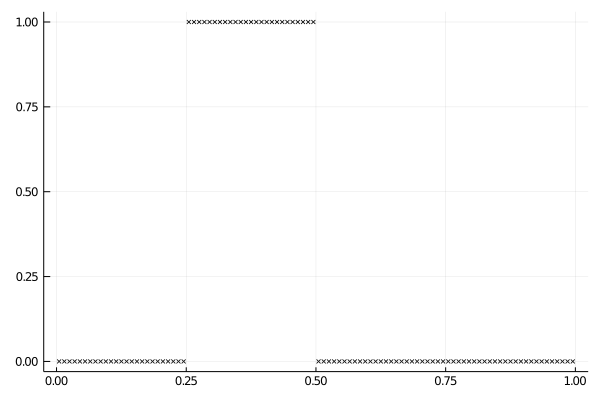

In [9]:
using Plots

pos_data = Array{Float64,1}(undef,0)
var_data = Array{Float64,1}(undef,0)

for idx = 1 : length(my_mesh.CELLs)
    push!(pos_data, my_mesh.CELLs[idx].CENTER_POS)
    push!(var_data, my_mesh.CELLs[idx].CELL_VAR[end])
end

plot(pos_data, var_data, seriestype=:scatter, markershape = :xcross, markersize = 2,
                                               markercolor = :black, legend = false)